In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import RobustScaler
import seaborn as sns

In [2]:
df = pd.read_csv("ANTM.JK.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2005-09-29,432.588074,436.787964,407.388763,432.588074,304.904572,76180670.0
1,2005-09-30,457.787384,457.787384,432.588074,457.787384,322.666016,105493978.0
2,2005-10-03,470.387024,474.586914,440.987854,470.387024,331.546692,59712955.0
3,2005-10-04,474.586914,482.986694,466.187164,474.586914,334.506927,56236668.0
4,2005-10-05,482.986694,482.986694,466.187164,482.986694,340.427429,31319315.0


In [3]:
df.isnull().sum()

Date         0
Open         1
High         1
Low          1
Close        1
Adj Close    1
Volume       1
dtype: int64

In [4]:
df.dropna(inplace=True)

In [5]:
df["Date"] = pd.to_datetime(df["Date"] ,infer_datetime_format=True)
df1 = df.set_index(["Date"])

In [6]:
df1.describe()

,Open,High,Low,Close,Adj Close,Volume
count,3807.000000,3807.000000,3807.000000,3807.000000,3807.000000,3.807000e+03
mean,1207.953241,1230.793315,1185.663883,1207.159945,1047.459832,6.858102e+07
std,664.882117,679.635933,649.243280,665.202070,495.685067,1.308133e+08
min,290.000000,294.000000,285.000000,287.000000,280.434296,0.000000e+00
25%,768.578796,780.000000,751.779297,765.000000,713.299744,1.420484e+07
50%,957.573608,978.573059,945.000000,957.573608,902.836792,3.421840e+07
75%,1595.956055,1621.155273,1570.756714,1595.956055,1347.260193,7.306722e+07
max,4409.878418,4451.877441,4115.886719,4241.883301,3190.000000,2.186653e+09


<AxesSubplot:>

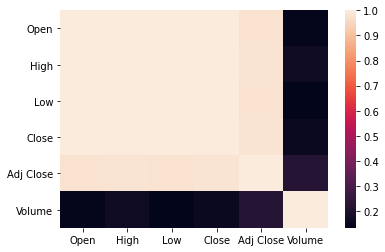

In [7]:
sns.heatmap(df1.corr())

Volume less corr. then others 

In [8]:
df1.drop(["Volume"],axis=1,inplace=True)

In [9]:
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
adf_test(df1['Open'])

Results of Dickey-Fuller Test:
Test Statistic                   -2.507554
p-value                           0.113647
#Lags Used                       25.000000
Number of Observations Used    3781.000000
Critical Value (1%)              -3.432081
Critical Value (5%)              -2.862305
Critical Value (10%)             -2.567177
dtype: float64


In [10]:
#Splitting dataset
column_indices = {name: i for i, name in enumerate(df1.columns)}
n = len(df1)
train_df = df1[0:int(n*0.9)] #90% of data for training 
test_df = df1[int(n*0.9):] # 10% data for testing section

num_features = df.shape[1]

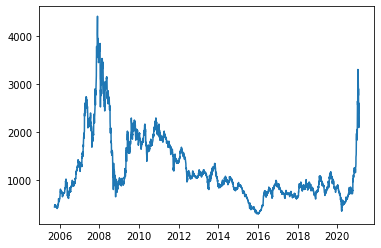

In [11]:
plt.plot(df1['Open'])

In [12]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [13]:
def create_dataset(X, y, time_steps=1):

    Xs, ys = [], []

    for i in range(len(X) - time_steps):

        v = X.iloc[i:(i + time_steps)].values

        Xs.append(v)

        ys.append(y.iloc[i + time_steps])

    return np.array(Xs), np.array(ys)

In [14]:
time_steps = 15

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train_df, train_df.Open, time_steps)

X_test, y_test = create_dataset(test_df, test_df.Open, time_steps)

print(X_train.shape, y_train.shape)

(3411, 15, 5) (3411,)


In [15]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,input_shape=(X_train.shape[1], X_train.shape[2]))))

model.add(tf.keras.layers.Dropout(rate=0.2))

model.add(tf.keras.layers.Dense(units=1))

model.compile(loss='mean_squared_error', optimizer='adam')

In [16]:
history = model.fit(

    X_train, y_train,

    epochs=30,

    batch_size=32,

    validation_split=0.3,

    shuffle=False

)

Epoch 1/30
75/75 [==============================] - 9s 49ms/step - loss: 0.2624 - val_loss: 0.0055
Epoch 2/30
75/75 [==============================] - 3s 35ms/step - loss: 0.1657 - val_loss: 0.0044
Epoch 3/30
75/75 [==============================] - 3s 34ms/step - loss: 0.0579 - val_loss: 0.0041
Epoch 4/30
75/75 [==============================] - 2s 32ms/step - loss: 0.0377 - val_loss: 0.0028
Epoch 5/30
75/75 [==============================] - 2s 32ms/step - loss: 0.0385 - val_loss: 0.0024
Epoch 6/30
75/75 [==============================] - 3s 34ms/step - loss: 0.0355 - val_loss: 0.0022
Epoch 7/30
75/75 [==============================] - 3s 36ms/step - loss: 0.0269 - val_loss: 0.0019
Epoch 8/30
75/75 [==============================] - 3s 35ms/step - loss: 0.0230 - val_loss: 0.0017
Epoch 9/30
75/75 [==============================] - 3s 34ms/step - loss: 0.0281 - val_loss: 0.0016
Epoch 10/30
75/75 [==============================] - 3s 36ms/step - loss: 0.0280 - val_loss: 0.0014
Epoch 11/

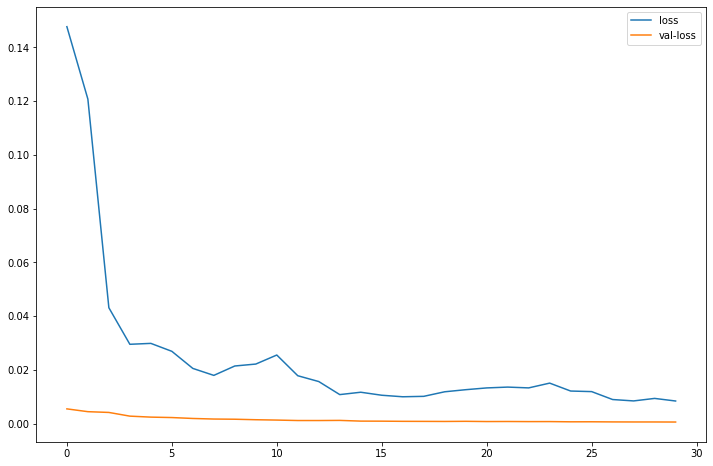

In [86]:
plt.figure(figsize=(12,8))
plt.plot(history.history["loss"],label="loss")
plt.plot(history.history["val_loss"],label="val-loss")
plt.legend()

In [18]:
y_pred = model.predict(X_test)

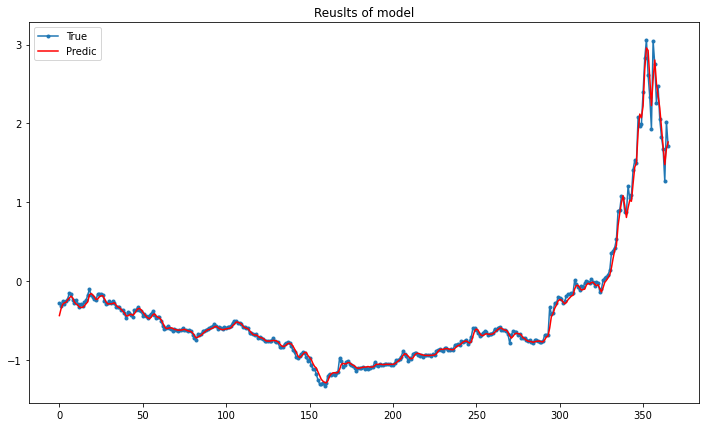

In [25]:
plt.figure(figsize=(12,7))
plt.plot(y_test,marker='.',label="True")
plt.plot(y_pred,'r',label="Predic")
plt.title("Reuslts of model")
plt.legend()